# Imports

In [1]:
import pandas as pd

# disable chained assignments
pd.options.mode.chained_assignment = None 
import os, gc
from darts import TimeSeries

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import seed_everything

# this stops pytorch from logging GPU info each time your model predicts something
# https://github.com/Lightning-AI/lightning/issues/3431
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

# for some warning bugs from darts
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from models import *
from utils import *
from splits import *
from plotter import *

SHOW_IMAGE = True
VERBOSE = True
Split = Baseline

In [2]:
# ## Result folder
output_folder = 'results_NHiTS'
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

# Config

In [3]:
@dataclass
class Config:
    static_features = ['AgeDist', 'HealthDisp']
    past_features = ['DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
    known_future = ['SinWeekly', 'CosWeekly']
    time_index = 'TimeFromStart' # note that this is an index feature commonly used by all timeseries models

    features =  static_features + past_features + known_future
    targets = ['Cases']
    group_id = 'FIPS'
    selected_columns = features + targets
    input_sequence_length = 13
    output_sequence_length = 15
    batch_size = 128
    epochs = 4
    learning_rate = 1e-3
    early_stopping_patience = 5
    seed = 7

seed_everything(Config.seed)
targets = Config.targets
group_id = Config.group_id
time_index = Config.time_index
input_sequence_length = Config.input_sequence_length
output_sequence_length = Config.output_sequence_length

Global seed set to 7


# Preprocessing

In [4]:
df = pd.read_csv('Data/COVID_Top_100_counties.csv')
df['Date'] = to_datetime(df['Date'])
df[time_index] = df[time_index].astype(int)

df.head(3)

,FIPS,AgeDist,HealthDisp,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,Deaths,TimeFromStart,LinearSpace,SinWeekly,CosWeekly
0,2261,0.014,8.8,2020-02-29,0.0,0.0,0.0,0.5,0.0,0.0,0,0.029,-0.975,-0.223
1,2261,0.014,8.8,2020-03-01,0.0,0.0,0.0,0.5,0.0,0.0,1,0.029,-0.782,0.623
2,2261,0.014,8.8,2020-03-02,0.0,0.0,0.0,0.5,0.0,0.0,2,0.029,0.000,1.000


## Split and scale

In [5]:
train_df, val_df, test_df = split_data(df, Split, input_sequence_length)
train_df, val_df, test_df, feature_scaler, target_scaler = scale_data(
    train_df, val_df, test_df, Config.features, targets
)

Shapes: train (64000, 14), validation (2800, 14), test (2800, 14).


## Create covariates

In [6]:
from numpy import round, mean, float32

def get_covariates(df:pd.DataFrame, tail_cut=False):
    if tail_cut:
        cutoff = df[time_index].max() - output_sequence_length + 1
        df = df[df[time_index]<cutoff]

    series = TimeSeries.from_group_dataframe(
        df, time_col=time_index, group_cols=group_id,
        static_cols=Config.static_features, value_cols=targets,
    )
    past_covariates = TimeSeries.from_group_dataframe(
        df, group_cols=group_id,
        time_col = time_index, value_cols=Config.past_features
    )

    # timeseries has default precision float64, this doesn't match 
    # with pl trainer which has precision float32
    for covariates in [series, past_covariates]:
        for index in range(len(covariates)):
            covariates[index] = covariates[index].astype(float32)

    return series, past_covariates

In [20]:
train_series, train_past_covariates = get_covariates(train_df)
val_series, val_past_covariates = get_covariates(val_df)

# Model

## Build

In [8]:
from darts.models import NHiTSModel
from pytorch_lightning.trainer import Trainer
from torch.nn.modules import MSELoss
from torch.optim import Adam

In [22]:
model = NHiTSModel(
    input_chunk_length=input_sequence_length, 
    output_chunk_length=output_sequence_length,
    batch_size=Config.batch_size, loss_fn=MSELoss(),
    optimizer_cls=Adam,    
    optimizer_kwargs={'lr': Config.learning_rate}
)

## Training

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=Config.early_stopping_patience,
    min_delta=0
)

checkpoint = ModelCheckpoint(
    dirpath=output_folder, monitor="val_loss", filename="best-{epoch}"
)

model.fit(
    train_series, val_series=val_series, verbose=VERBOSE,
    past_covariates=train_past_covariates, val_past_covariates=val_past_covariates,
    trainer = Trainer(
        accelerator= "gpu", devices= 1, max_epochs=Config.epochs,
        callbacks=[early_stopping, checkpoint], 
        enable_progress_bar=VERBOSE, logger=False
    )
)
gc.collect()

20

# Historical forecast

## Util

In [11]:
def historical_forecast(
    model, df, series_list, past_list, target_scaler
):
    prediction_start = df[time_index].min() + input_sequence_length

    preds = []
    # each county is a unique timeseries
    for fips, series, past in zip(
        df[group_id].unique(), series_list, past_list
    ):

        if len(series) > (input_sequence_length + output_sequence_length):
            # list of predictions with sliding window
            county_preds = model.historical_forecasts(
                series, 
                past_covariates=past,
                start=prediction_start,
                retrain=False, last_points_only=False, verbose=VERBOSE,
                forecast_horizon=output_sequence_length, stride=1,
            )
            # reseting index here is ok since only one time column
            county_preds = pd.concat(
                [pred.pd_dataframe().reset_index() for pred in county_preds], axis=0
            )
        else:
            county_preds = model.predict(
                output_sequence_length,
                series, n_jobs=-1,
                past_covariates=past,
                verbose=VERBOSE
            )
            county_preds = county_preds.pd_dataframe().reset_index()

        county_preds[group_id] = fips
        preds.append(county_preds)
        # if len(preds)==2:
        #     break

    # conver the predicted list to a dataframe
    preds = pd.concat(preds, axis=0).reset_index(drop=True)
    # scale up
    preds[targets] = target_scaler.inverse_transform(
        preds[targets].values
    )
    # round and remove negative targets since infection can't be neg
    preds[targets] = preds[targets].apply(round)
    for target in targets:
        preds.loc[preds[target]<0, target] = 0
        
    # since this is sliding window, some cases will have multiple prediction with different forecast horizon
    preds = preds.groupby([group_id, time_index], axis=0)[targets].aggregate(mean)

    preds.rename({target:'Predicted_'+target for target in targets}, axis=1, inplace=True)

    target_df = df[[group_id, time_index, 'Date'] + targets].copy().reset_index(drop=True)
    target_df[targets] = target_scaler.inverse_transform(target_df[targets]).astype(int)

    merge_keys = [group_id, time_index]
    prediction_df = preds.merge(target_df[['Date'] + merge_keys + targets], on=merge_keys, how='inner')
    gc.collect()

    return prediction_df

## Train

In [12]:
print('\nTrain prediction')
train_prediction_df = historical_forecast(
    model, train_df, train_series, train_past_covariates, target_scaler
)

show_result(train_prediction_df, targets)
print(train_prediction_df.describe())


Train prediction


  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not iterable

In [ ]:
for target in targets:
    plot_predition(
        train_prediction_df, target, show_image=SHOW_IMAGE,
        figure_path=os.path.join(output_folder, f'Summed_{target}_Train.jpg')
    )

## Validation

In [13]:
val_series, val_past_covariates = get_covariates(val_df, tail_cut=True)
print('\nValidation prediction')
val_prediction_df = historical_forecast(
    model, val_df, val_series, val_past_covariates, target_scaler
)

show_result(val_prediction_df, targets)
print(val_prediction_df.describe())


Validation prediction
Target Cases, MAE 241.17, RMSE 445.8, RMSLE 2.4407, SMAPE 0.97547. NNSE 0.66605.

               FIPS  TimeFromStart  Predicted_Cases        Cases
count   1500.000000    1500.000000      1500.000000  1500.000000
mean   25826.550000     647.000000       266.738007   399.709333
std    15942.307612       4.321935       358.336578   629.780614
min     2261.000000     640.000000         0.000000     0.000000
25%    12026.000000     643.000000        72.000000     0.000000
50%    25023.000000     647.000000       163.000000   198.000000
75%    39038.500000     651.000000       338.000000   509.250000
max    55079.000000     654.000000      4442.000000  8204.000000


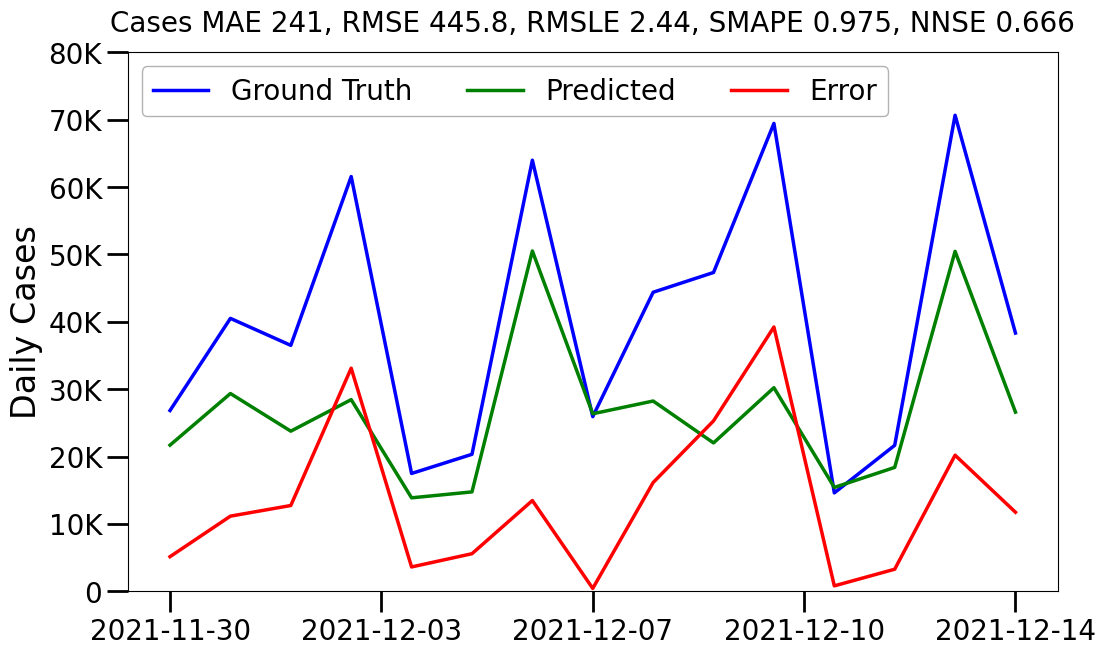

In [15]:
for target in targets:
    plot_predition(
        val_prediction_df, target, show_image=SHOW_IMAGE,
        figure_path=os.path.join(output_folder, f'Summed_{target}_Validation.jpg')
    )

## Test

In [16]:
test_series, test_past_covariates = get_covariates(test_df, tail_cut=True)
print('\nTest prediction')
test_prediction_df = historical_forecast(
    model, test_df, test_series, test_past_covariates, target_scaler
)

show_result(test_prediction_df, targets)
print(test_prediction_df.describe())


Test prediction
Target Cases, MAE 632.37, RMSE 1320, RMSLE 2.4851, SMAPE 1.0415. NNSE 0.55675.

               FIPS  TimeFromStart  Predicted_Cases         Cases
count   1500.000000    1500.000000      1500.000000   1500.000000
mean   25826.550000     662.000000       405.798676    917.220000
std    15942.307612       4.321935       481.830078   1479.870301
min     2261.000000     655.000000         0.000000      0.000000
25%    12026.000000     658.000000       113.000000      0.000000
50%    25023.000000     662.000000       272.000000    439.000000
75%    39038.500000     666.000000       478.500000   1160.000000
max    55079.000000     669.000000      5048.000000  20618.000000


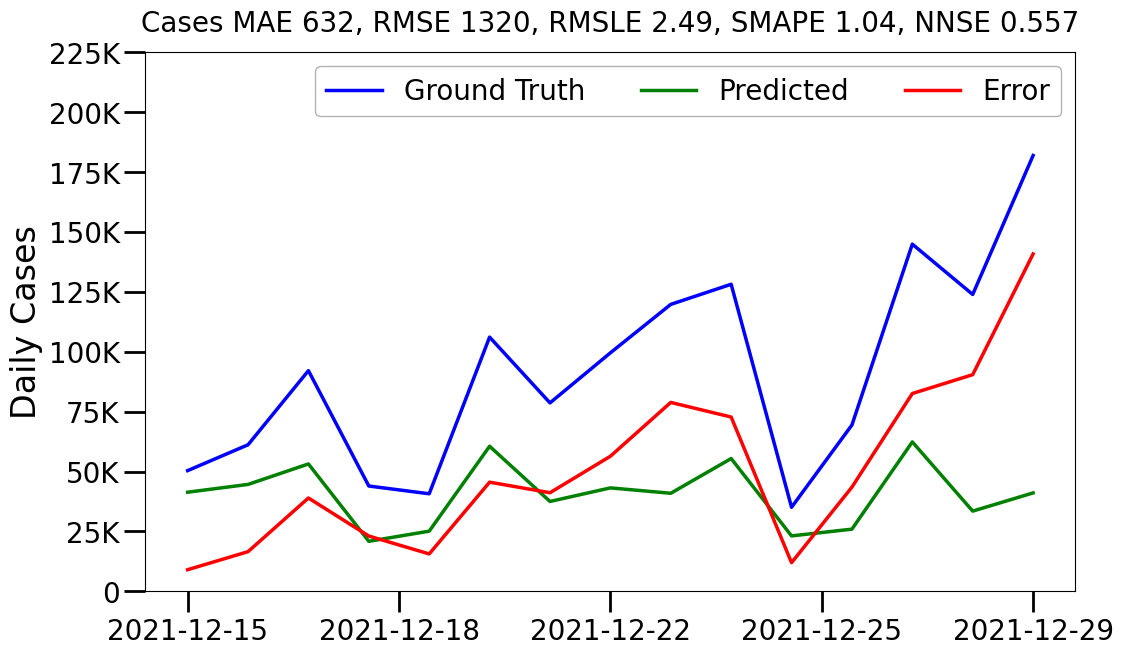

In [17]:
for target in targets:
    plot_predition(
        test_prediction_df, target, show_image=SHOW_IMAGE,
        figure_path=os.path.join(output_folder, f'Summed_{target}_Test.jpg')
    )

## Dump

In [ ]:
train_prediction_df['Split'] = 'train'
val_prediction_df['Split'] = 'validation'
test_prediction_df['Split'] = 'test'
merged_df = pd.concat([train_prediction_df, val_prediction_df, test_prediction_df], axis=0)
merged_df.drop(columns=['TimeFromStart'], inplace=True)

merged_df.to_csv(os.path.join(output_folder, 'predictions.csv'), index=False)